In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import importlib
import numpy.ma as ma
import cartopy.crs as ccrs
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import matplotlib
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 
import sys
import h5py

/home/km/anaconda3/envs/pyocean35/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


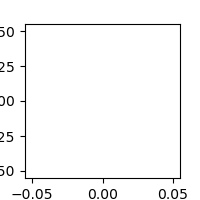

In [95]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [ ]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [12]:
sys.path.append("/media/hdd2/SOSE_1_12/myScripts/")

In [3]:
dfmg = pd.read_csv("/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/dfmg_corrected_DIST_GLINE.csv")
dfgamma = pd.read_csv("gamman.csv", names=['PROFILE_NUMBER', 'gamman'])
dfmg['gamman'] = dfgamma['gamman']
del dfmg['Unnamed: 0']
dfmg['JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])
dfmg.loc[(dfmg['gamman'] < 0), "gamman"] = np.nan

In [8]:
windEk = xr.open_dataset("/media/data/Datasets/Winds/wek_ERA_interim_2004_2017.nc")
windsMerged = xr.open_mfdataset("/media/data/Datasets/Winds/ERA_interim/*.nc")
windsMergedSH = windsMerged.sel(latitude=slice(-60, -89.25))

In [4]:
acrossASF = pd.read_excel("AcrossSlopeTransects.xlsx")

In [5]:
bathy = xr.open_dataset('/media/data/Datasets/Bathymetry/GEBCO_2014_2D.nc')

In [6]:
import plot_AcrossASF as pltASF
importlib.reload(pltASF)

<module 'plot_AcrossASF' from '/media/data/Datasets/MEOP/MEOP-CTD_2018-04-10/myScripts/plot_AcrossASF.py'>

In [11]:
acrossASF.columns

Index(['Unnamed: 0', 'REGION', 'PROFILE_NUMBERS', 'POSITION_LABEL', 'LEVELS',
       'month', 'zonal', 'merid', 'wek', 'echodepth', 'SHELF_BREAK_ind'],
      dtype='object')

(102,)


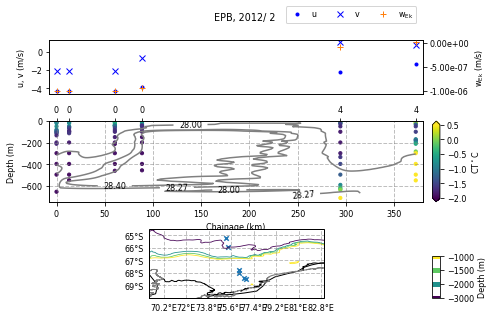

In [9]:
i = 86
region = acrossASF.loc[i].REGION
pltASF.plot_AcrossASF(acrossASF.loc[i], dfmg, windsMergedSH, windEk, bathy=bathy, region=region, 
                      wd=7, ht=5, show=1, savefig=False, p2pdist=True,
                      savename="./Images/acrossASF/acASF_"+region+"_"+str(i)+"_new.png", 
                      levels=[28, 28.27, 28.4]) 
#[28, 28.1, 28.27, 28.3, 28.4, 28.5, 28.6, 28.7]

In [13]:
dfmg.columns

Index(['JULD', 'LATITUDE', 'LONGITUDE', 'PLATFORM_NUMBER', 'POSITION_QC',
       'PRES_ADJUSTED', 'PRES_ADJUSTED_ERROR', 'PRES_ADJUSTED_QC',
       'PROFILE_NUMBER', 'PSAL_ADJUSTED', 'PSAL_ADJUSTED_ERROR',
       'PSAL_ADJUSTED_QC', 'TEMP_ADJUSTED', 'TEMP_ADJUSTED_ERROR',
       'TEMP_ADJUSTED_QC', 'DEPTH', 'DENSITY_INSITU', 'POT_DENSITY', 'CTEMP',
       'SA', 'DIST_GLINE', 'ECHODEPTH', 'gamman', 'SHELF_BREAK_PROFILE'],
      dtype='object')

In [23]:
i = 224

def list_latlons(acASF):
    profs = acASF.PROFILE_NUMBERS
    profs = [int(x) for x in profs.split(',')]
    year = dfmg.loc[dfmg.PROFILE_NUMBER.isin([profs[0]]), "JULD"].dt.year.values[0]
    month = dfmg.loc[dfmg.PROFILE_NUMBER.isin([profs[0]]), "JULD"].dt.month.values[0]
    region = acASF.REGION
    lonlats = dfmg.loc[dfmg.PROFILE_NUMBER.isin(profs), ["LONGITUDE", "LATITUDE"]].drop_duplicates().values
    return lonlats

In [24]:
i = 224
lonlats = list_latlons(acrossASF.loc[i])

In [28]:
lonlats[:, 0].mean()

-40.614799999999995

In [35]:
salt = h5py.File("/media/hdd2/SOSE_1_12/SaltForEllyn_Monthly.mat", 'r')
theta  = h5py.File("/media/hdd2/SOSE_1_12/ThetaForEllyn_Monthly.mat", 'r')

In [36]:
depthax = salt['z'].value
timemon = salt['tmon'].value.T[0]
year = 2006
timeax = [np.datetime64("2006-01-15")]
timediffs = np.diff(salt['tmon'].value.T[0])
for td in timediffs:
    timeax.append(timeax[-1] + np.timedelta64(int(td), 'D'))

In [41]:
js = 0 #time index to start with
je = 62 # time index to end with
pathtofile = []
for i in range(js,je):
    pathtofile.append("/media/hdd2/SOSE_1_12/sigma0/sigma0_"+str(i)+".nc")
sigma = xr.open_mfdataset(paths=pathtofile, concat_dim="Time")
sigma.coords['Time'] = timeax[js:je]

In [46]:
pathtofile = []
for i in range(js, je):
    pathtofile.append("/media/hdd2/SOSE_1_12/salt/salt_"+str(i)+".nc")
salt = xr.open_mfdataset(paths=pathtofile, concat_dim="Time")
salt.coords['Time'] = timeax[js:je]

In [48]:
pathtofile = []
for i in range(js, je):
    pathtofile.append("/media/hdd2/SOSE_1_12/temp/temp_"+str(i)+".nc")
temp = xr.open_mfdataset(paths=pathtofile, concat_dim="Time")
temp.coords['Time'] = timeax[js:je]

In [54]:
grid = h5py.File("/media/hdd2/SOSE_1_12/grid.mat", "r")

In [55]:
echodepth = grid['Depth'][0:643, :]

In [57]:
echodepth = xr.Dataset({'depth':(['YC', 'XC'], echodepth)},
                        coords={'YC':(['YC'], sigma.YC.values, {'axis':'Y'}),
                                'XC':(['XC'], sigma.XC.values, {'axis':'X'})})

In [68]:
def plot_transect(along=325, time='2006-01-01', overlay="temperature", CF_vmin=None, CF_vmax=None, 
                  Contour_vmin=None, Contour_vmax=None, 
                  maxlat=-60, minlat=-78, maxdepth=None, Contour_levels=[], CF_levels=[], timeind=0):
    if along<0:
        along = along + 360
    transect_echodepth = echodepth.sel(XC=along, method="nearest").where(
        (echodepth.YC<maxlat) & (echodepth.YC > minlat) ).depth
        
    pot_density = sigma.sel(XC=along, Time=time, method="nearest").where(
                      (sigma.YC<maxlat) & (sigma.YC > minlat) & (sigma.Z > -transect_echodepth) ).sigma0
    salinity = salt.sel(XC=along, Time=time, method="nearest").where((salt.YC<maxlat) & 
                            (salt.YC > minlat) & (salt.Z > -transect_echodepth)).salt
    temperature = temp.sel(XC=along, Time=time, method="nearest").where((temp.YC<maxlat) & 
                            (temp.YC > minlat) & (temp.Z > -transect_echodepth)).temp
    
    #plot the data
    plt.close(1)
    plt.figure(1, figsize=(9,5))
    ax = plt.subplot()
    yy, zz = np.meshgrid(salt.YC, salt.Z)
    
    if(overlay == "temperature"):
        CF = ax.contourf(salt.YC, salt.Z, temperature, vmin=CF_vmin, vmax=CF_vmax, extend="both", levels=CF_levels)
        Contour_gn = ax.contour(salt.YC, salt.Z, pot_density, vmin=Contour_vmin, vmax=Contour_vmax, levels=Contour_levels,
                               colors='0.75')
        #ax.clabel(Contour_gn, colors='k', fontsize=10, fmt='%3.2f')
    elif(overlay == "salinity"):
        CF = ax.contourf(salt.YC, salt.Z, salinity, vmin=CF_vmin, vmax=CF_vmax, extend="both", levels=CF_levels)
        Contour_gn = ax.contour(salt.YC, salt.Z, pot_density, vmin=Contour_vmin, vmax=Contour_vmax, levels=Contour_levels,
                               colors='0.75')
        #ax.clabel(Contour_gn, colors='k', fontsize=10, fmt='%3.2f')
    elif(overlay == "potential density"):
        CF = ax.contourf(salt.YC, salt.Z, pot_density, vmin=CF_vmin, vmax=CF_vmax, levels=CF_levels, extend="both")
    else:
        raise NameError("overlay should be either temperature or salinity")
        
    if maxlat:
        ax.set_xlim(-78, maxlat)
    if minlat:
        ax.set_xlim(minlat, -60)
    if maxlat and minlat:
        ax.set_xlim(minlat, maxlat)
    if maxdepth:
        ax.set_ylim(maxdepth, 0)
        
    ax.clabel(Contour_gn, colors='0.75', fontsize=10, fmt='%3.2f')
    plt.colorbar(CF)
    plt.show()


<IPython.core.display.Javascript object>


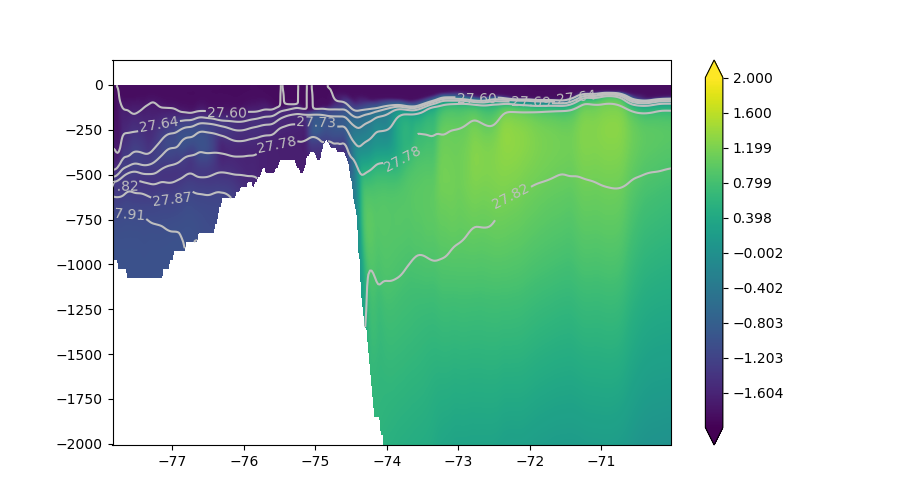

In [98]:
minlat, maxlat = -78, -70
maxdepth = -3000
plot_transect(along= -37+360, time='2009-09-15', Contour_vmin=27, Contour_vmax=29, maxlat=maxlat, 
              minlat=minlat, maxdepth=maxdepth, 
              Contour_levels= np.linspace(27.6, 28, 10), 
              CF_vmin=-2, CF_vmax=2.0, 
              CF_levels=np.linspace(-2,2.0, 1000))

In [82]:
i = 208
lonlats = list_latlons(acrossASF.loc[i])
lonlats[:, 0].mean()

-29.913324999999997